# IMPORTING PACKAGE

In [ ]:
import pandas as pd
import numpy as np
import random as rnd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm, skew
from scipy import stats 

from sklearn.preprocessing import LabelEncoder

from scipy.special import boxcox1p

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

# DATA OVERVIEWS

In [588]:
train_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
sample_submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")

In [589]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [590]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [591]:
sample_submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [592]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [593]:
column_names = train_df.columns
column_names

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [594]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [595]:
train_df.describe(include=['O'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [596]:
concatenated_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
concatenated_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [597]:
y_train = train_df["SalePrice"]
print(y_train.head())
# Drop the 'SalePrice' column from the concatenated DataFrame
concatenated_df.drop('SalePrice', axis=1, inplace=True)

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64


In [598]:
all_data_na = (concatenated_df.isnull().sum() / len(concatenated_df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:20]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(10)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
MasVnrType,60.500171
FireplaceQu,48.646797
LotFrontage,16.649538
GarageFinish,5.447071
GarageQual,5.447071
GarageCond,5.447071


## List of features to be dropped due to low data point

In [599]:
# List of features to be dropped
features_to_drop = ["Id",'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu', 'LotFrontage']

# Drop the specified features from the concatenated DataFrame
concatenated_df.drop(features_to_drop, axis=1, inplace=True)

# Now, concatenated_df does not contain the specified features
concatenated_df.head()

# "LotArea" , "SaleCondition"  , "OverallCond"

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,84,0,0,0,0,0,12,2008,WD,Normal


# Deleted columns due to almost many data depends on single variable

<Figure size 600x600 with 0 Axes>

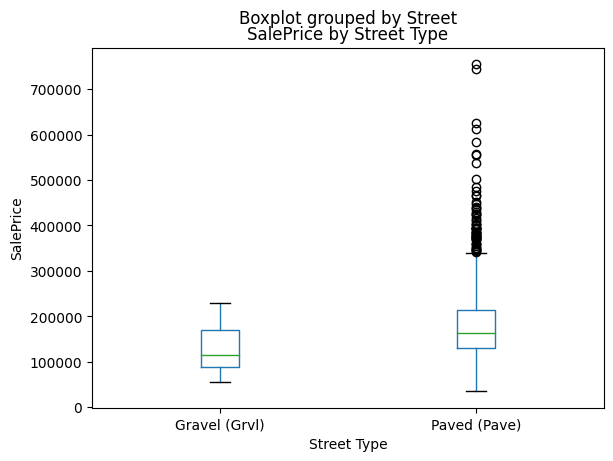

         count           mean           std      min       25%       50%  \
Street                                                                     
Grvl       6.0  130190.500000  65446.253991  55993.0   88250.0  114250.0   
Pave    1454.0  181130.538514  79446.597317  34900.0  130000.0  163000.0   

             75%       max  
Street                      
Grvl    169650.0  228950.0  
Pave    214000.0  755000.0  


In [600]:
# Box plot to compare SalePrice for Gravel (Grvl) and Paved (Pave) road access
plt.figure(figsize=(6, 6))
train_df.boxplot(column='SalePrice', by='Street', grid=False)
plt.title('SalePrice by Street Type')
plt.xlabel('Street Type')
plt.ylabel('SalePrice')
plt.xticks([1, 2], ['Gravel (Grvl)', 'Paved (Pave)'])
plt.show()
# Summary statistics for SalePrice grouped by Street type
summary_stats = train_df.groupby('Street')['SalePrice'].describe()
print(summary_stats)

In [601]:
# List of columns to be deleted due to single value
deleted_col_due_to_single_value=["Street","LandContour","Utilities","LandSlope","Condition2","RoofMatl","BsmtFinSF2",
                                 "Heating","LowQualFinSF","Functional","GarageQual","GarageCond","EnclosedPorch","3SsnPorch",
                                 "PoolArea","MiscVal","KitchenAbvGr","ScreenPorch","BsmtHalfBath","CentralAir","BsmtFinType2",
                                 "Electrical"]

# List of columns to be deleted due to not being dependent
deleted_col_due_to_not_depend =["MoSold","YrSold","SaleType"]

# Concatenated DataFrame after dropping specified columns
concatenated_df.drop(deleted_col_due_to_single_value + deleted_col_due_to_not_depend, axis=1, inplace=True)

# Now, concatenated_df does not contain the specified columns
concatenated_df.head()

,MSSubClass,MSZoning,LotArea,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,...,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,SaleCondition
0,60,RL,8450,Reg,Inside,CollgCr,Norm,1Fam,2Story,7,...,0,Attchd,2003.0,RFn,2.0,548.0,Y,0,61,Normal
1,20,RL,9600,Reg,FR2,Veenker,Feedr,1Fam,1Story,6,...,1,Attchd,1976.0,RFn,2.0,460.0,Y,298,0,Normal
2,60,RL,11250,IR1,Inside,CollgCr,Norm,1Fam,2Story,7,...,1,Attchd,2001.0,RFn,2.0,608.0,Y,0,42,Normal
3,70,RL,9550,IR1,Corner,Crawfor,Norm,1Fam,2Story,7,...,1,Detchd,1998.0,Unf,3.0,642.0,Y,0,35,Abnorml
4,60,RL,14260,IR1,FR2,NoRidge,Norm,1Fam,2Story,8,...,1,Attchd,2000.0,RFn,3.0,836.0,Y,192,84,Normal


In [602]:
concatenated_df.columns

Index(['MSSubClass', 'MSZoning', 'LotArea', 'LotShape', 'LotConfig',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'SaleCondition'],
      dtype='object')

In [603]:
concatenated_df.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,...,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000
mean,57.137718,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,560.772104,1051.777587,...,1.568003,0.380267,2.860226,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811
std,42.517628,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,439.543659,440.766258,...,0.552969,0.502872,0.822693,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493
min,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,220.000000,793.000000,...,1.000000,0.000000,2.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000
50%,50.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,467.000000,989.500000,...,2.000000,0.000000,3.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000
75%,70.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,805.500000,1302.000000,...,2.000000,1.000000,3.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000
max,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,2336.000000,6110.000000,...,4.000000,2.000000,8.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000


In [604]:
concatenated_df.describe(include=['O'])

,MSZoning,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,...,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,HeatingQC,KitchenQual,GarageType,GarageFinish,PavedDrive,SaleCondition
count,2915,2919,2919,2919,2919,2919,2919,2919,2918,2918,...,2838,2837,2837,2840,2919,2918,2762,2760,2919,2919
unique,5,4,5,25,9,5,8,6,15,16,...,4,4,4,6,5,4,6,3,3,6
top,RL,Reg,Inside,NAmes,Norm,1Fam,1Story,Gable,VinylSd,VinylSd,...,TA,TA,No,Unf,Ex,TA,Attchd,Unf,Y,Normal
freq,2265,1859,2133,443,2511,2425,1471,2310,1025,1014,...,1283,2606,1904,851,1493,1492,1723,1230,2641,2402


# Data Changing according to need (LabelEncoder)

In [605]:
concatenated_df["YearBuilt"] = 2023 - concatenated_df["YearBuilt"]
concatenated_df["YearRemodAdd"] = 2023 - concatenated_df["YearRemodAdd"]
concatenated_df["GarageYrBlt"] = 2023 - concatenated_df["GarageYrBlt"]

In [606]:
label_encoder = LabelEncoder()

categorical_columns = concatenated_df.select_dtypes(include=['O']).columns.tolist()

for column in categorical_columns:
    concatenated_df[column] = label_encoder.fit_transform(concatenated_df[column])
    
concatenated_df.head()

,MSSubClass,MSZoning,LotArea,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,...,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,SaleCondition
0,60,3,8450,3,4,5,2,0,5,7,...,0,1,20.0,1,2.0,548.0,2,0,61,4
1,20,3,9600,3,2,24,1,0,2,6,...,1,1,47.0,1,2.0,460.0,2,298,0,4
2,60,3,11250,0,4,5,2,0,5,7,...,1,1,22.0,1,2.0,608.0,2,0,42,4
3,70,3,9550,0,0,6,2,0,5,7,...,1,5,25.0,2,3.0,642.0,2,0,35,0
4,60,3,14260,0,2,15,2,0,5,8,...,1,1,23.0,1,3.0,836.0,2,192,84,4


In [607]:
concatenated_df.fillna(0, inplace=True)

all_data_null = (concatenated_df.isnull().sum() / len(concatenated_df)) * 100
all_data_null = all_data_null.drop(all_data_null[all_data_null == 0].index).sort_values(ascending=False)[:30]
missing_data_null = pd.DataFrame({'Missing Ratio' :all_data_null})
missing_data_null.head(20)

,Missing Ratio


# Making log normal SalePrice

/tmp/ipykernel_32/3992027034.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train , fit=norm)



 mu = 180921.20 and sigma = 79415.29



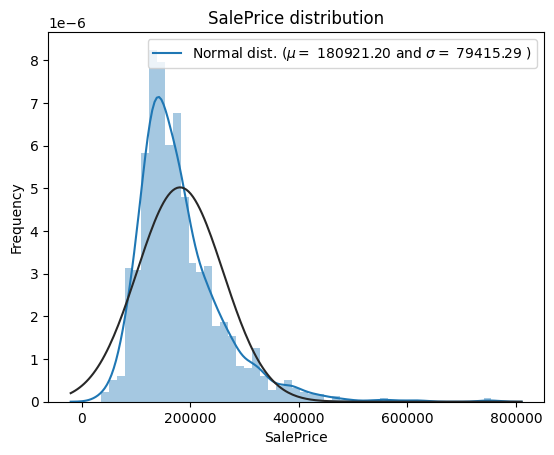

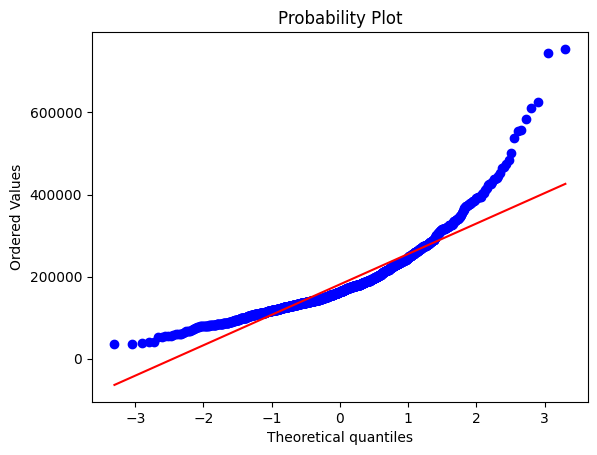

In [608]:
sns.distplot(y_train , fit=norm)
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

In [609]:
y_train = np.log1p(y_train)
y_train.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

/tmp/ipykernel_32/3992027034.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train , fit=norm)



 mu = 12.02 and sigma = 0.40



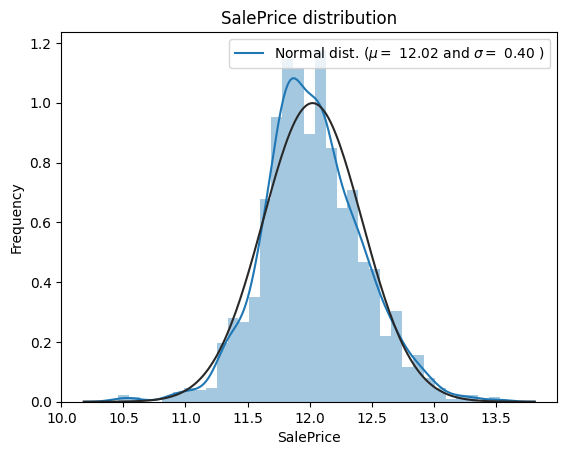

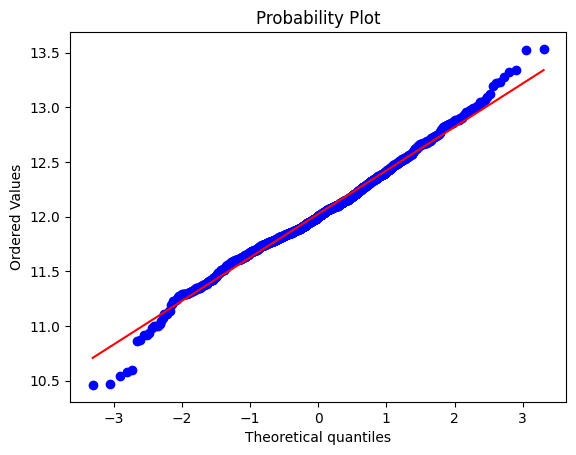

In [610]:
sns.distplot(y_train , fit=norm)
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

# Checking skewness of data points

In [611]:
numeric_feats = concatenated_df.dtypes[concatenated_df.dtypes != "object"].index
skewed_feats = concatenated_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head()


Skew in numerical features: 



,Skew
LotArea,12.822431
Condition1,2.983114
MasVnrArea,2.613592
OpenPorchSF,2.535114
BldgType,2.192261



 mu = 12.02 and sigma = 0.40



/tmp/ipykernel_32/1384892702.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_see , fit=norm)


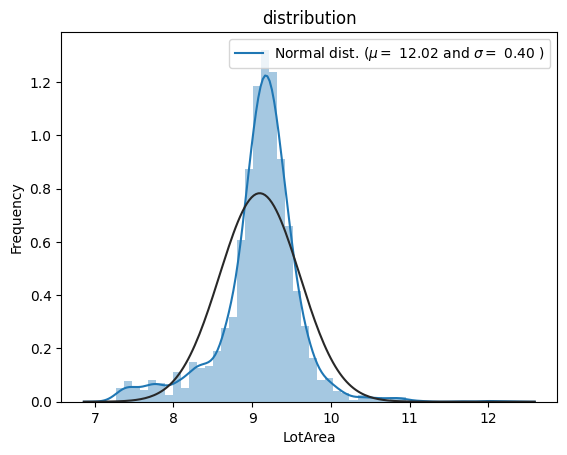

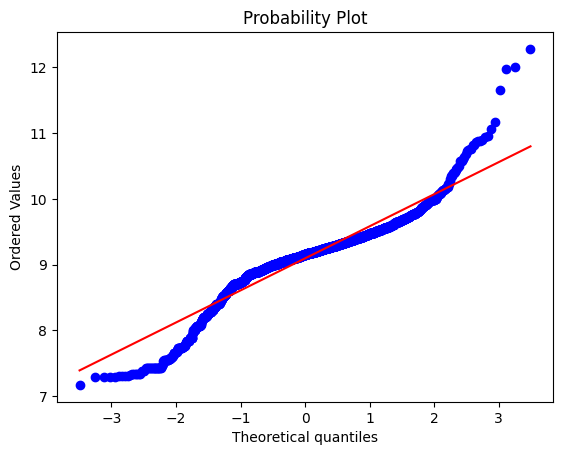

In [612]:
y_train_see = np.log1p(concatenated_df["LotArea"])
# y_train_see = (concatenated_df["LotArea"])

sns.distplot(y_train_see , fit=norm)
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('distribution')

fig = plt.figure()
res = stats.probplot(y_train_see, plot=plt)
plt.show()

In [613]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    concatenated_df[feat] = boxcox1p(concatenated_df[feat], lam)
    
concatenated_df[skewed_features] = np.log1p(concatenated_df[skewed_features])
concatenated_df

There are 47 skewed numerical features to Box Cox transform


,MSSubClass,MSZoning,LotArea,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,...,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,SaleCondition
0,1.899792,0.932543,3.006286,0.932543,1.036855,1.116990,0.785871,0.000000,1.116990,1.235549,...,0.000000,0.548389,1.580793,0.548389,0.785871,2.442892,0.785871,0.000000,1.904295,1.036855
1,1.580793,0.932543,3.030723,0.932543,0.785871,1.636608,0.548389,0.000000,0.785871,1.181627,...,0.548389,0.548389,1.832319,0.548389,0.785871,2.403525,0.785871,2.303605,0.000000,1.036855
2,1.899792,0.932543,3.060922,0.000000,1.036855,1.116990,0.785871,0.000000,1.116990,1.235549,...,0.548389,0.548389,1.610122,0.548389,0.785871,2.466024,0.785871,0.000000,1.800615,1.036855
3,1.941469,0.932543,3.029726,0.000000,0.000000,1.181627,0.785871,0.000000,1.116990,1.235549,...,0.548389,1.116990,1.648940,0.785871,0.932543,2.478071,0.785871,0.000000,1.748353,0.000000
4,1.899792,0.932543,3.105714,0.000000,0.785871,1.490229,0.785871,0.000000,1.116990,1.281654,...,0.548389,0.548389,1.623687,0.548389,0.932543,2.535893,0.785871,2.198766,1.989891,1.036855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2.154092,1.036855,2.713464,0.932543,1.036855,1.357341,0.785871,0.932543,1.116990,1.036855,...,0.000000,1.181627,0.000000,0.932543,0.000000,0.000000,0.785871,0.000000,0.000000,1.036855
2915,2.154092,1.036855,2.708937,0.932543,1.036855,1.357341,0.785871,1.036855,1.116990,1.036855,...,0.000000,1.036855,1.865743,0.785871,0.548389,2.293966,0.785871,0.000000,1.636608,0.000000
2916,1.580793,0.932543,3.168931,0.932543,1.036855,1.389125,0.785871,0.000000,0.785871,1.116990,...,0.548389,1.116990,1.913058,0.785871,0.785871,2.454008,0.785871,2.410303,0.000000,0.000000
2917,1.993002,0.932543,3.046737,0.932543,1.036855,1.389125,0.785871,0.000000,1.181627,1.116990,...,0.000000,1.181627,0.000000,0.932543,0.000000,0.000000,0.785871,1.977023,1.722259,1.036855


# Different Regression Model

In [614]:
# Get the index where the train and test data were originally separated
train_data_index = len(train_df)
test_data_index = len(concatenated_df) - len(test_df)

# Split the concatenated data back into train and test sets
X_train = concatenated_df[:train_data_index]
X_test = concatenated_df[test_data_index:]

# Now, train_data contains the training data, and test_data contains the test data


In [615]:
X_test

,MSSubClass,MSZoning,LotArea,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,...,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,SaleCondition
1460,1.580793,0.785871,3.067093,0.932543,1.036855,1.417851,0.548389,0.000000,0.785871,1.116990,...,0.000000,0.548389,1.908716,0.785871,0.548389,2.506331,0.785871,2.120896,0.000000,1.036855
1461,1.580793,0.932543,3.105807,0.000000,0.000000,1.417851,0.785871,0.000000,0.785871,1.181627,...,0.000000,0.548389,1.921519,0.785871,0.548389,2.314334,0.785871,2.367682,1.756500,1.036855
1462,1.899792,0.932543,3.099953,0.000000,1.036855,1.281654,0.785871,0.000000,1.116990,1.116990,...,0.548389,0.548389,1.660732,0.000000,0.785871,2.414081,0.785871,2.222744,1.739942,1.036855
1463,1.899792,0.932543,3.038094,0.000000,1.036855,1.281654,0.785871,0.000000,1.116990,1.181627,...,0.548389,0.548389,1.648940,0.000000,0.785871,2.408389,0.785871,2.347524,1.756500,1.036855
1464,2.082052,0.932543,2.904563,0.000000,1.036855,1.610122,0.785871,1.036855,0.785871,1.281654,...,0.000000,0.548389,1.712948,0.548389,0.785871,2.425022,0.785871,0.000000,1.983543,1.036855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2.154092,1.036855,2.713464,0.932543,1.036855,1.357341,0.785871,0.932543,1.116990,1.036855,...,0.000000,1.181627,0.000000,0.932543,0.000000,0.000000,0.785871,0.000000,0.000000,1.036855
2915,2.154092,1.036855,2.708937,0.932543,1.036855,1.357341,0.785871,1.036855,1.116990,1.036855,...,0.000000,1.036855,1.865743,0.785871,0.548389,2.293966,0.785871,0.000000,1.636608,0.000000
2916,1.580793,0.932543,3.168931,0.932543,1.036855,1.389125,0.785871,0.000000,0.785871,1.116990,...,0.548389,1.116990,1.913058,0.785871,0.785871,2.454008,0.785871,2.410303,0.000000,0.000000
2917,1.993002,0.932543,3.046737,0.932543,1.036855,1.389125,0.785871,0.000000,1.181627,1.116990,...,0.000000,1.181627,0.000000,0.932543,0.000000,0.000000,0.785871,1.977023,1.722259,1.036855


In [616]:
X_train

,MSSubClass,MSZoning,LotArea,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,...,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,SaleCondition
0,1.899792,0.932543,3.006286,0.932543,1.036855,1.116990,0.785871,0.0,1.116990,1.235549,...,0.000000,0.548389,1.580793,0.548389,0.785871,2.442892,0.785871,0.000000,1.904295,1.036855
1,1.580793,0.932543,3.030723,0.932543,0.785871,1.636608,0.548389,0.0,0.785871,1.181627,...,0.548389,0.548389,1.832319,0.548389,0.785871,2.403525,0.785871,2.303605,0.000000,1.036855
2,1.899792,0.932543,3.060922,0.000000,1.036855,1.116990,0.785871,0.0,1.116990,1.235549,...,0.548389,0.548389,1.610122,0.548389,0.785871,2.466024,0.785871,0.000000,1.800615,1.036855
3,1.941469,0.932543,3.029726,0.000000,0.000000,1.181627,0.785871,0.0,1.116990,1.235549,...,0.548389,1.116990,1.648940,0.785871,0.932543,2.478071,0.785871,0.000000,1.748353,0.000000
4,1.899792,0.932543,3.105714,0.000000,0.785871,1.490229,0.785871,0.0,1.116990,1.281654,...,0.548389,0.548389,1.623687,0.548389,0.932543,2.535893,0.785871,2.198766,1.989891,1.036855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.899792,0.932543,2.993757,0.932543,1.036855,1.281654,0.785871,0.0,1.116990,1.181627,...,0.548389,0.548389,1.636608,0.548389,0.785871,2.403525,0.785871,0.000000,1.786737,1.036855
1456,1.580793,0.932543,3.090809,0.932543,1.036855,1.468050,0.785871,0.0,0.785871,1.181627,...,0.785871,0.548389,1.820110,0.785871,0.785871,2.422340,0.785871,2.340358,0.000000,1.036855
1457,1.941469,0.932543,3.019270,0.932543,1.036855,1.181627,0.785871,0.0,1.116990,1.235549,...,0.785871,0.548389,1.983543,0.548389,0.548389,2.264079,0.785871,0.000000,1.899792,1.036855
1458,1.580793,0.932543,3.033037,0.932543,1.036855,1.417851,0.785871,0.0,0.785871,1.116990,...,0.000000,0.548389,1.952696,0.785871,0.548389,2.252472,0.785871,2.351333,0.000000,1.036855


In [617]:
y_train

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1460, dtype: float64

In [618]:
# Initialize the models
linear_reg = LinearRegression()
decision_tree_reg = DecisionTreeRegressor(random_state=0)
random_forest_reg = RandomForestRegressor(n_estimators=100, random_state=0)
gradient_boosting_reg = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
svr_reg = SVR(kernel='rbf')
xgb_reg = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

stack_gen = StackingCVRegressor(regressors=(linear_reg, decision_tree_reg, random_forest_reg, gradient_boosting_reg, svr_reg,lightgbm,xgb_reg),
                                meta_regressor=xgb_reg,
                                use_features_in_secondary=True)

In [619]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X_train, y=y_train):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return rmse

### From here [coefficients] values comes

In [620]:
# BY RELATIVE ERROR OF MEAN AND STD


# score = cv_rmse(linear_reg)
# print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()),  )

# score = cv_rmse(decision_tree_reg)
# print("decision_tree_reg: {:.4f} ({:.4f})\n".format(score.mean(), score.std()),  )

# score = cv_rmse(random_forest_reg)
# print("random_forest_reg net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()),  )

# score = cv_rmse(gradient_boosting_reg)
# print("gradient_boosting_reg: {:.4f} ({:.4f})\n".format(score.mean(), score.std()),  )

# score = cv_rmse(svr_reg)
# print("svr_reg: {:.4f} ({:.4f})\n".format(score.mean(), score.std()),  )

# score = cv_rmse(xgb_reg)
# print("xgb_reg: {:.4f} ({:.4f})\n".format(score.mean(), score.std()),  )

# score = cv_rmse(lightgbm)
# print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()),  )

# score = cv_rmse(stack_gen)
# print("stack_gen: {:.4f} ({:.4f})\n".format(score.mean(), score.std()),  )

# from here [coefficients] values comes

In [621]:
# Train the models
linear_reg.fit(X_train, y_train)
decision_tree_reg.fit(X_train, y_train)
random_forest_reg.fit(X_train, y_train)
gradient_boosting_reg.fit(X_train, y_train)
svr_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
lightgbm.fit(X_train, y_train)
stack_gen.fit(X_train, y_train)

[21:55:20] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current valu

StackingCVRegressor(meta_regressor=XGBRegressor(base_score=None, booster=None,
                                                callbacks=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=0.4603,
                                                early_stopping_rounds=None,
                                                enable_categorical=False,
                                                eval_metric=None,
                                                feature_types=None,
                                                gamma=0.0468, gpu_id=None,
                                                grow_policy=None,
                                                importance_type=None,
                                                interaction_constraints=None,
                                                learning_...
                                             importance_type=None,
                                             interaction_constraints=None,
                                             learning_rate=0.05, max_bin=None,
                                             max_cat_threshold=None,
                                             max_cat_to_onehot=None,
                                             max_delta_step=None, max_depth=3,
                                             max_leaves=None,
                                             min_child_weight=1.7817,
                                             missing=nan,
                                             monotone_constraints=None,
                                             n_estimators=2200, n_jobs=None,
                                             nthread=-1, num_parallel_tree=None,
                                             predictor=None, ...)),
                    use_features_in_secondary=True)

In [622]:
X_test.fillna(0, inplace=True)
all_data_na = (X_test.isnull().sum())
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:20]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(10)

/tmp/ipykernel_32/4187289647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.fillna(0, inplace=True)


,Missing Ratio


In [623]:
# Make predictions using the trained models
linear_reg_preds = linear_reg.predict(X_test)
decision_tree_preds = decision_tree_reg.predict(X_test)
random_forest_preds = random_forest_reg.predict(X_test)
gradient_boosting_preds = gradient_boosting_reg.predict(X_test)
svr_preds = svr_reg.predict(X_test)
xgb_preds = xgb_reg.predict(X_test)
lightgbm_preds = lightgbm.predict(X_test)
stack_gen_preds = stack_gen.predict(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


In [624]:
# Create a DataFrame with predictions
predictions_df = pd.DataFrame({
    'LinearReg': linear_reg_preds,
    'DecisionTree': decision_tree_preds,
    'RandomForest': random_forest_preds,
    'GradientBoosting': gradient_boosting_preds,
    'SVR': svr_preds,
    'XGBoost': xgb_preds,
    'Lightgbm': lightgbm_preds,
    'StackGen': stack_gen_preds
})


In [625]:
coefficients={
    'LinearReg': 0.30802729485992525,
    'RandomForest': 0.02367726228440147,
    'GradientBoosting': 0.19984912388986045,
    'SVR': 0.027966944415869426,
    'XGBoost': 0.20027774920275693,
    'Lightgbm': 0.09594349003874773,
    'StackGen': 0.14425813530843876
}

In [626]:
# Calculate the weighted average predictions from all models
predictions_df['WeightedSalePrice'] = sum(predictions_df[model] * coefficients[model] for model in coefficients.keys())

# Get the 'Id' column from your test dataset
test_ids = sample_submission['Id']

predictions_df['WeightedSalePrice'] = np.expm1(predictions_df['WeightedSalePrice'])
# predictions_df['WeightedSalePrice'] = np.expm1(X_test)

# Create a DataFrame with 'Id' and 'WeightedSalePrice' columns
submission_df_2 = pd.DataFrame({'Id': test_ids, 'SalePrice': predictions_df['WeightedSalePrice']})
# Save the submission DataFrame to a CSV file
submission_df_2.to_csv('submission.csv', index=False)

submission_df_2.head()

,Id,SalePrice
0,1461,117448.871247
1,1462,159711.235199
2,1463,185766.413949
3,1464,195933.493042
4,1465,181289.652951


# Score: 0.12061 